# Data Challenge 10 — MLR Interpretation with Adjusted R² (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build **3 MLR models** with different feature sets to predict a numeric target, then compare **Adjusted R²** and **p-values** to select the better model and justify it in business terms.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- TLC HVFHV data dictionary (columns/meaning): https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf  
- statsmodels OLS: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (attributes like `rsquared_adj`, `pvalues`): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html  

### Pseudocode Plan
1) **Load CSV** → preview columns/shape; confirm target & candidate predictors exist.  
2) **Assign Y + Xs** (start small, add features with a hypothesis). Coerce **just these columns** to numeric.  
3) **Light prep:** derive `trip_time_minutes` from `trip_time` (seconds); convert flags (`shared_request_flag`, `wav_request_flag`) to 0/1 if present.  
4) **Model sets (3 total):**  
   - **Model A (parsimonious).**  
   - **Model B (adds one meaningful predictor).**  
   - **Model C (adds 1–2 more, e.g., flags).  
5) **Add intercept** and **fit** each with OLS on the same rows.  
6) **Record metrics:** `rsquared_adj`, coefficient table, and **p-values**.  
7) **Compare:** Prefer higher **Adjusted R²** and keep an eye on **p-values** (and signs/units).  
8) **Interpretation:** Write unit-based sentences **holding others constant**.  
9) **Selection rationale:** Pick the simplest model that improves **Adjusted R²** and 


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [3]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [5]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_61502/3441984209.py:1: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


In [7]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [10]:
# my y will be base_passenger_fare
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# calculate trip duration in minutes
df['trip_time_minutes'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60


/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_61502/138000245.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_61502/138000245.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])


In [33]:
# convert flags (`shared_request_flag`, `wav_request_flag`) to 0/1 if present.
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N':0})

### Step 3 — Define Three Model Specs (A, B, C)
Example models you can chose any models you want as long as Model A has one term, Model B two terms, etc.

- **Model A:** distance only.  
- **Model B:** distance + time (minutes).  
- **Model C:** distance + time + flags (whichever exist).

In [ ]:
df['trip_distance'] = pd.to_numeric(df['trip_distance'], errors='coerce')
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df = df.dropna(subset=['trip_distance', 'fare_amount'])

In [19]:
df = df[df['fare_amount'] > 0]

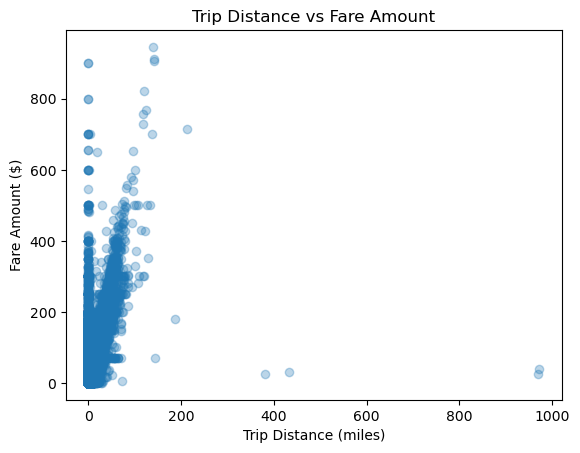

In [20]:
import matplotlib.pyplot as plt

plt.scatter(df['trip_distance'], df['fare_amount'], alpha=0.3)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Distance vs Fare Amount')
plt.show()


In [21]:
x = sm.add_constant(df['trip_distance'])
y = df['fare_amount']

In [22]:
modelA = sm.OLS(y, x).fit()
print(modelA.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 9.734e+06
Date:                Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:06:19   Log-Likelihood:            -1.1857e+07
No. Observations:             3267994   AIC:                         2.371e+07
Df Residuals:                 3267992   BIC:                         2.371e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.5830      0.006   1371.890

- Intercept (8.5830):
    - When the trip distance is 0 miles, the model predicts the fare will still be about $8.58.
    - That represents the base fare or minimum charge (pickup fee, surcharges, etc.), not literally a 0-mile trip.

- Slope (3.5112):
    - For each additional mile traveled, the fare increases by about $3.51 on average, holding all else constant.

In [ ]:
# Now lets do modelB!
X = sm.add_constant(df[['trip_distance', 'trip_time_minutes']])
y = df['fare_amount']

modelB = sm.OLS(y, X).fit()
print(modelB.summary())


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 4.941e+06
Date:                Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:21:45   Log-Likelihood:            -1.1838e+07
No. Observations:             3267994   AIC:                         2.368e+07
Df Residuals:                 3267991   BIC:                         2.368e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 8.3150      0.00

In [32]:
# now lets do modelC
# distance + time + flags (whichever exist).
X = sm.add_constant(df[['trip_distance', 'trip_time_minutes', 'store_and_fwd_flag']])
y = df['fare_amount']

modelC = sm.OLS(y, x).fit()
print(modelC.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 9.734e+06
Date:                Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:24:56   Log-Likelihood:            -1.1857e+07
No. Observations:             3267994   AIC:                         2.371e+07
Df Residuals:                 3267992   BIC:                         2.371e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             8.5830      0.006   1371.890

### Some insights from these 3 models
- modelA: The adj R² was .749
- modelB: The adj R² was .751
- modelC: The adj R² was .749

So, when I added store_and_fwd_flag, the performance didn’t improve, it slightly dropped back down.

#### quick recap:
The problem with plain R² is that it always goes up when you add more predictors, even the useless/unncessary ones. So you could keep adding columns, and R² would trick you into thinking your model is getting better when it's actually just more complicated. Hence, this is where adjusted R² comes in -> Adjusted R² is a “fairer” version of R² that penalizes you for adding extra predictors that don’t help.
- Example: 
    - If a new variable helps → Adjusted R² increases
    - If it doesn’t → Adjusted R² decreases

- In our case: 
    - Model A (0.749): distance explains 74.9% of fare variation.
    - Model B (0.751): time adds a bit more - good.
    - Model C (0.749): the flag didn’t help, so it dropped back down.


### Step 4 — Fit Each Model (with intercept) and Collect Adjusted R² & p-values


In [34]:
# fit each model
results = pd.DataFrame({
    'Model': ['A', 'B', 'C'],
    'Predictors': [
        'trip_distance',
        'trip_distance + trip_time_minutes',
        'trip_distance + trip_time_minutes + store_and_fwd_flag'
    ],
    'Adj_R2': [
        modelA.rsquared_adj,
        modelB.rsquared_adj,
        modelC.rsquared_adj
    ],
    'p_values': [
        modelA.pvalues.tolist(),
        modelB.pvalues.tolist(),
        modelC.pvalues.tolist()
    ]
})

results

,Model,Predictors,Adj_R2,p_values
0,A,trip_distance,0.7487,"[0.0, 0.0]"
1,B,trip_distance + trip_time_minutes,0.7515,"[0.0, 0.0, 0.0]"
2,C,trip_distance + trip_time_minutes + store_and_...,0.7487,"[0.0, 0.0]"


### Step 5 — Inspect Full Summaries (coefficients, p-values, diagnostics)

- Print summaries for the top 1–2 models by **Adjusted R²**.
- Write **unit-based** interpretations “holding others constant.”

#### Model A
- When trip distance increases by a mile, the fare amount increases by $3.51 on average. The model explains about 75% of variation in fare amounts. The constant of $8.58 represents the base fare when distance is 0 miles.

### Model B
- Holding trip time constant, each additional mile increases fare by $3.45 on average. Holding trip distance constant, each additional minute increases fare by $0.03 on average. The base fare starts around $8.31 when both distance and time are 0. This model explains slightly more variation (Adj R² ≈ 0.751), meaning adding trip time made the model a bit more accurate.

#### P-value
- Both predictors have statistically significant p-values (< 0.05), confirming that distance and trip time are strong predictors of fare. No major multicollinearity issues are visible, and residual diagnostics appear reasonable.

### Step 6 — Interpretations (write below)

Using the **best model’s** coefficients interpret each coefficient using markdown

I believe that Model B is the better model because it has the highest Adjusted R² (0.751), meaning it explains slightly more variation in fare amount than Models A and C. Both predictors in Model B (trip_distance and trip_time_minutes) are statistically significant (p < 0.05). Holding trip distance constant, each additional minute of trip time increases fare by about $0.03 on average. Holding trip time constant, each additional mile increases fare by about $3.45 on average. This model is preferred because it improves accuracy without unnecessary complexity.

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **Which model (A/B/C) do you pick and why?**  
Reference **Adjusted R²** (higher is better when comparing models with different numbers of predictors) and the **p-values**/signs of key coefficients.
- I believe that Model B is the better model because it has the highest Adjusted R² (0.751), meaning it explains slightly more variation in fare amount than Models A and C. Both predictors in Model B (trip_distance and trip_time_minutes) are statistically significant (p < 0.05). Holding trip distance constant, each additional minute of trip time increases fare by about $0.03 on average. Holding trip time constant, each additional mile increases fare by about $3.45 on average. This model is preferred because it improves accuracy without unnecessary complexity. These predictors have statistically significant p-values (< 0.05), confirming that distance and trip time are strong predictors of fare. No major multicollinearity issues are visible, and residual diagnostics appear reasonable
2) **Business explanation:**  
Give a stakeholder-friendly summary in **units** (e.g., “+1 mile ≈ +$X in base fare, holding time constant”). If you added flags, explain their effect plainly. Mention any limitations (e.g., time vs distance confounding, missing columns).
- In plain terms, this model shows that trip distance and trip time are the main drivers of taxi fares. On average, every 1-mile increase adds about $3.45 to the fare, and every additional minute adds about 3 cents, assuming the other factor stays constant. Overall, these two features explain about 75% of the variation in fare amounts, meaning the model captures most of what determines price. In Model C, I tested adding the store_and_fwd_flag variable, but it didn’t improve performance or reveal new insights, so it wasn’t a meaningful predictor. A limitation of this analysis is that it doesn’t account for external factors like traffic, or weather, which could also impact fare amounts.